In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import glob
import numpy as np 
from numpy import genfromtxt
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from mpl_toolkits import mplot3d
from tqdm import tqdm_notebook
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt
from utils import project, mae_score, FIGSIZE, DPI, FONTSIZE, EV_i, CEV_d


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def get_threshold_eigennumbers(pca, data, threshold=0.99, plot=False):
    # define the i-th normalized eigenvalue - expected variance
    # calculating the list of the EVs and CEVs
    # evnum is the first eigenvalue having CEV more or equal to 0.99
    EV = []
    CEV = []
    ev_num = -1
    
    explained_variance = pca.explained_variance_
    for i in range(explained_variance.shape[0]):
        EV.append(EV_i(i, explained_variance))
        CEV.append(CEV_d(i, explained_variance))
        if (ev_num == -1 and CEV[i] >= threshold):
            ev_num = i
    #plot EV/CEVs
    if plot:
#         fig = plt.figure(figsize=(10,5), dpi=DPI)

#         plt.subplot(121)
#         plt.title("Explained variance", fontsize=FONTSIZE)
#         plt.xlabel("Number of PCs", fontsize=FONTSIZE)
#         plt.grid(linestyle="dotted")
#         plt.plot(EV, "o-")

# #         plt.subplot(122)
#         plt.title("Cumulative explained variance", fontsize=FONTSIZE)
#         plt.axhline(linewidth=1, y=0.95, color='r')
#         plt.axhline(linewidth=1, y=0.9, color='r')
#         plt.axhline(linewidth=1, y=0.8, color='r')
#         plt.xlabel("Number of PCs", fontsize=FONTSIZE)
#         plt.grid(linestyle="dotted")
        plt.plot(CEV, "-", label=LABEL, linewidth=0.75)        
        
            
    return ev_num
    
def project(data, plot=False):
    pca = PCA(svd_solver='full',random_state=42)
    pca.fit(data)
    ev_num = get_threshold_eigennumbers(pca, data, plot=plot)
    data_centered = data - data.mean(0)[None,...]
    pca_proj = PCA(n_components=ev_num,svd_solver='full',random_state=42)
    data_projected = pca_proj.fit_transform(data)
    if plot:
        print('EV_NUM',ev_num,"REC_ERROR:",np.abs(pca_proj.inverse_transform(data_projected) - data_centered).mean())
    return data_projected, pca_proj

In [3]:
folders = ['HMP']

DATASET: HMP, TAX: o
EV_NUM 18 REC_ERROR: 0.005768806440804397
DATASET: HMP, TAX: f
EV_NUM 36 REC_ERROR: 0.003908256795135102
DATASET: HMP, TAX: g
EV_NUM 51 REC_ERROR: 0.001836817495312233



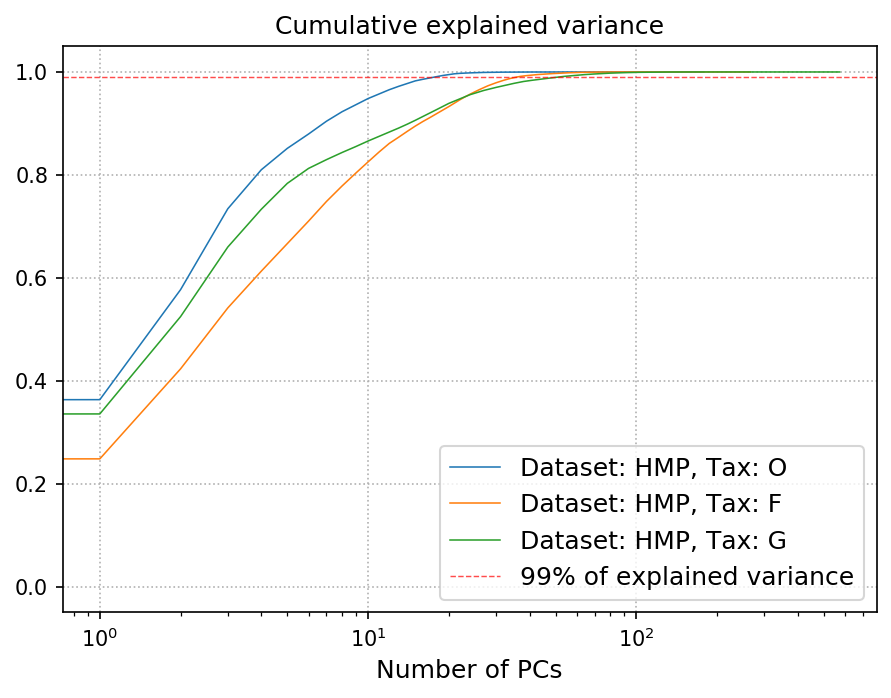

In [4]:
SAVE=True
MERGED=False

results = defaultdict(list)

datasets_taxes = defaultdict(dict)
if MERGED:
    iterator = range(1)
else:
    iterator = folders
    
fig = plt.figure(figsize=(7,5), dpi=DPI)
plt.title("Cumulative explained variance", fontsize=FONTSIZE)
plt.xlabel("Number of PCs", fontsize=FONTSIZE)
plt.grid(linestyle="dotted")

for f in tqdm_notebook(iterator):
    for t in ['o', 'f', 'g']: # 
        dataset_name = 'HMP' if f == 'ptb' else f
        LABEL = f'Dataset: {dataset_name}, Tax: {t.capitalize()}'
        print(f'DATASET: {f}, TAX: {t}')
        dataframe = pd.read_csv(f'./merged_datasets/pivot_{t}.csv' if MERGED else f'{f}/pivot_{t}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
        dataframe = dataframe.drop('Unnamed: 0', axis = 1).values
        data_projected, pca = project(dataframe, plot=True)
        data_reconstructed = pca.inverse_transform(data_projected)
        mae = mae_score(data_reconstructed, dataframe)
        
#         plt.title(f'DATASET: {dataset_name}, TAX: {t}') # , MAE: {mae}'
        results['Dataset'].append('HMP' if f == 'ptb' else f)
        results['nMAE'].append(mae)
        results['Taxonomic leve'].append(t.capitalize()) 
        
        plt.legend(fontsize=FONTSIZE)
        
        if SAVE:
            if MERGED:
                np.savetxt(f'./merged_datasets_proj/proj_{t}.csv', data_projected, delimiter = ';')
            else:
                np.savetxt(f'./separate_datasets_proj/{f}_proj_{t}.csv', data_projected, delimiter = ';')
plt.axhline(0.99,linestyle='--', linewidth=0.7, color='r', label='99% of explained variance', alpha=0.7)
plt.legend(fontsize=FONTSIZE)
plt.title("Cumulative explained variance", fontsize=FONTSIZE)
plt.xscale('log')

plt.show()

In [5]:
ls -la separate_datasets_proj

total 46728
drwxrwxr-x  2 ibulygin ibulygin     4096 июня  29 18:33 ./
drwxrwxr-x 21 ibulygin ibulygin     4096 июня  29 18:34 ../
-rw-rw-r--  1 ibulygin ibulygin  8489572 нояб.  4  2020 AGP_proj_f.csv
-rw-rw-r--  1 ibulygin ibulygin 12629534 нояб.  4  2020 AGP_proj_g.csv
-rw-rw-r--  1 ibulygin ibulygin  3894644 нояб.  4  2020 AGP_proj_o.csv
-rw-rw-r--  1 ibulygin ibulygin    48128 мая   26 20:08 BLOBS_proj_f.npy
-rw-rw-r--  1 ibulygin ibulygin    48128 мая   26 20:10 BLOBS_proj_g.npy
-rw-rw-r--  1 ibulygin ibulygin    48128 мая   26 20:06 BLOBS_proj_o.npy
-rw-rw-r--  1 ibulygin ibulygin  4218685 июня  29 18:33 HMP_proj_f.csv
-rw-rw-r--  1 ibulygin ibulygin  5969367 июня  29 18:33 HMP_proj_g.csv
-rw-rw-r--  1 ibulygin ibulygin  2110296 июня  29 18:33 HMP_proj_o.csv
-rw-rw-r--  1 ibulygin ibulygin    24197 нояб.  4  2020 ibd_proj_f.csv
-rw-rw-r--  1 ibulygin ibulygin    26414 нояб.  4  2020 ibd_proj_g.csv
-rw-rw-r--  1 ibulygin ibulygin    13224 нояб.  4  2020 ibd_proj_o.csv
-rw-rw-r-- 